# FINAL PROJECT | Structure from Motion: <font color=red>Team C</font>
**ES 143 Computer Vision, Harvard University**

###Team members:
*(<font color=red>Nico Fidalgo, Sedik Sadik, Ashley Redhead</font>)*

###Instructions for running this notebook###

1. Create a copy of this notebook in a new folder titled `Structure From Motion Final Project` on your Google drive.
2. Download this ZIP file: **UPDATE THIS LINK FOR FINAL SUBMISSION** [data](https://drive.google.com/file/d/1StPPh7EilRKW-VJvedNTZV3nD8kqNOgp/view?usp=sharing) and place the ZIP file into the project folder.
3. You should now have 2 things in the `Structure From Motion Final Project` folder (this notebook `SfM.ipynb`, and `data.zip`).
4. Run the cells below.

# Setup

### Import Libraries

In [25]:
# Import Libraries
import cv2                                      # OpenCV
import numpy as np                              # NumPy
import os                                       # OS Module
import requests                                 # Requests
from pupil_apriltags import Detector            # Pupil Apriltags
import pickle                                   # Pickle
import glob                                     # Glob
import plotly.express as px                     # Plotly
import plotly.graph_objects as go               # More plotly libs
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt                 # Matplotlib
plt.rcParams['figure.figsize'] = [10, 10]       # Initialize figures

### Mount Google Drive

In [26]:
# Mount your google drive. This will launch a pop-up window for authentication.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Navigate to Project Folder

In [27]:
# Make Sure to place the data.zip into the working folder of this project

# cd into your working directory
%cd "/content/drive/My Drive/Structure From Motion Final Project"

/content/drive/.shortcut-targets-by-id/1-aWr6DFiBmVYfMnfmSAUpuAm1B7-Kpc4/Structure From Motion Final Project


### Unzip Media and Data Files

In [28]:
# COMMENTED OUT FOR NOW, FINAL SUBMISSION INCLUDE THIS
# folder_path = '.'
# zip_file_name = 'data.zip'
# zip_file_path = os.path.join(folder_path, zip_file_name)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     extract_path = '.'
#     zip_ref.extractall(extract_path)

# print(f"'{zip_file_name}' has been extracted to '{extract_path}'")

# Camera Calibration

### Introduction

In this section, we estimate the intrinsic parameters of a camera, such as focal length, principal point, and lens distortion coefficients. These parameters are necessary for accurately mapping the 3D world onto a 2D image. We will use `cv2.calibrateCamera` to extract the `calMatrix` and `distCoeffs`.

### calMatrix (K)

The `calMatrix` encodes the camera's focal length, principal point, skew, and aspect ratio.

### distCoeffs

The `distCoeffs` (distortion coefficients) in camera calibration primarily encode information about the lens distortion in the camera. These distortions can affect the accuracy of the image captured by the camera, especially when mapping the 3D world onto a 2D image plane.

### Code Explanation

This code performs camera calibration using images that contain AprilTag fiducials. AprilTags are a type of fiducial marker designed for camera calibration and robotic applications where precise measurements are required.

### Choice of Fiducial Board

In our code, we only use the fine board to calibrate our camera. This is because if a single board provides enough coverage across the camera's field of view and contains a sufficient number of identifiable points (tags), then one board is enough for accurate calibration.



In [29]:
# Get target IDs for april boards from Git repo
response = requests.get("https://github.com/Harvard-CS283/pset-data/raw/f1a90573ae88cd530a3df3cd0cea71aa2363b1b3/april/AprilBoards.pickle")
data = pickle.loads(response.content)
at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

In [30]:
# Helper function for detecting the april boards
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

def detect_aprilboard(img, board, apriltag_detector):
    """
    Detects April tags in a grayscale image.

    Usage: imgpoints, objpoints, tag_ids = detect_aprilboard(img, board, AT_detector)

    Input:
        image -- grayscale image
        board -- at_coarseboard or at_fineboard (list of dictionaries)
        AT_detector -- AprilTag Detector parameters

    Returns:
        imgpoints -- Nx2 numpy array of (x,y) image coords
        objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
        tag_ids -- Nx1 list of tag IDs
    """

    imgpoints=[]
    objpoints=[]
    tagIDs=[]
    imgtags = apriltag_detector.detect(img,
                                    estimate_tag_pose=False,
                                    camera_params=None,
                                    tag_size=None)
    if len(imgtags):
        brdtagIDs = [ sub['tag_id'] for sub in board ]
        imgtagIDs = [ sub.tag_id for sub in imgtags ]
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))
        if len(tagIDs):
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))
            objpoints = np.vstack([ sub['center'] for sub in objs ])
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))
            imgpoints = np.vstack([ sub.center for sub in imgs ])

    return imgpoints, objpoints, tagIDs

In [33]:
def extract_keyframes(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    index = 0
    keyframe_interval = 60
    frame_number = 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if index % keyframe_interval == 0:
            frame_name = f'keyframe_{str(frame_number).zfill(4)}.jpg'
            frame_path = os.path.join(output_folder, frame_name)
            if not os.path.exists(frame_path):
                cv2.imwrite(frame_path, frame)
                print(f"Keyframe saved at: {frame_path}")
            else:
                print(f"Keyframe already exists: {frame_path}")
            frame_number += 1
        index += 1

    cap.release()
    print("Done extracting keyframes.")

extract_keyframes('./media/calibration.MOV', './media/calibration_keyframes')
extract_keyframes('./media/mixed1.MOV', './media/mixed1_keyframes')
extract_keyframes('./media/book1.MOV', './media/book1_keyframes')
extract_keyframes('./media/book2.MOV', './media/book2_keyframes')
extract_keyframes('./media/deck.MOV', './media/deck_keyframes')
extract_keyframes('./media/hair_dryer.MOV', './media/hair_dryer_keyframes')
extract_keyframes('./media/currier_cap.MOV', './media/currier_cap_keyframes')

Keyframe saved at: ./media/calibration_keyframes/keyframe_0001.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0002.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0003.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0004.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0005.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0006.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0007.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0008.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0009.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0010.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0011.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0012.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0013.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0014.jpg
Keyframe saved at: ./media/calibration_keyframes/keyframe_0015

18 images:
0 ./media/calibration_keyframes/keyframe_0001.jpg: 80 imgpts, 80 objpts
1 ./media/calibration_keyframes/keyframe_0002.jpg: 80 imgpts, 80 objpts
2 ./media/calibration_keyframes/keyframe_0003.jpg: 80 imgpts, 80 objpts
3 ./media/calibration_keyframes/keyframe_0004.jpg: 0 imgpts, 0 objpts
4 ./media/calibration_keyframes/keyframe_0005.jpg: 80 imgpts, 80 objpts
5 ./media/calibration_keyframes/keyframe_0006.jpg: 80 imgpts, 80 objpts
6 ./media/calibration_keyframes/keyframe_0007.jpg: 80 imgpts, 80 objpts
7 ./media/calibration_keyframes/keyframe_0008.jpg: 80 imgpts, 80 objpts
8 ./media/calibration_keyframes/keyframe_0009.jpg: 80 imgpts, 80 objpts
9 ./media/calibration_keyframes/keyframe_0010.jpg: 80 imgpts, 80 objpts
10 ./media/calibration_keyframes/keyframe_0011.jpg: 80 imgpts, 80 objpts
11 ./media/calibration_keyframes/keyframe_0012.jpg: 80 imgpts, 80 objpts
12 ./media/calibration_keyframes/keyframe_0013.jpg: 80 imgpts, 80 objpts
13 ./media/calibration_keyframes/keyframe_0014.jpg: 

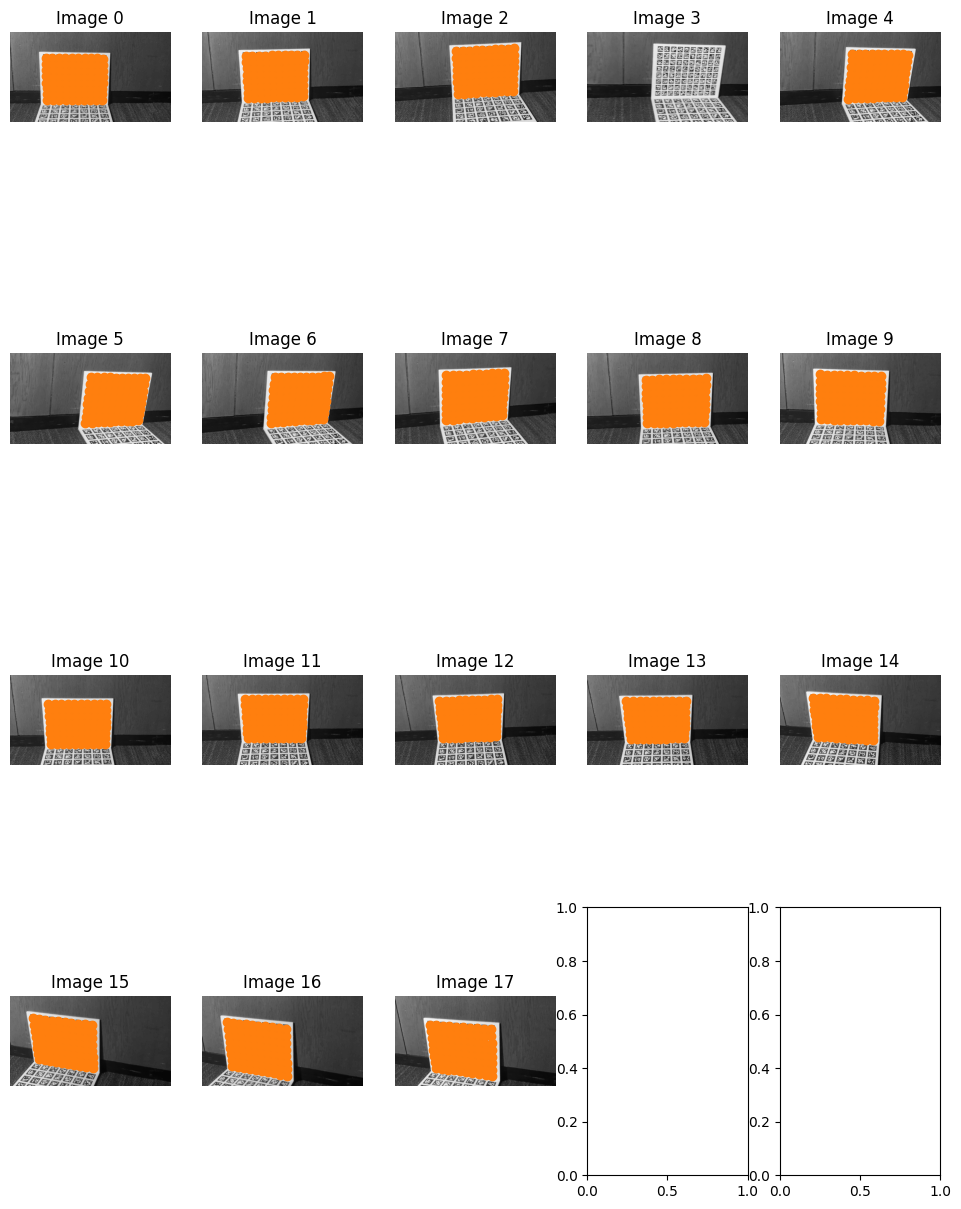

In [35]:
# Detect fiducials

# Here we detect fudicials and check to make sure that the algorithm is able to
# regonize a high enough margin of them so that one board will sufficiently calibrate
# our camera


N = 70
total_valid = 0

CALIBFILES = './media/calibration_keyframes/keyframe_*.jpg'

BOARD = at_fineboard

images = glob.glob(CALIBFILES)
assert images, "no calibration images matching: " + CALIBFILES
assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"
print("{} images:".format(len(images)))

calObjPoints = []
calImgPoints = []
num_plot_cols = 5
num_plot_rows = (len(images) + num_plot_cols - 1) // num_plot_cols
fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
axs = axs.flatten()

for count,fname in enumerate(images):
    orig = cv2.imread(fname)
    if len(orig.shape) == 3:
        img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    else:
        img = orig

    axs[count].imshow(img / 255.0, cmap="gray")
    axs[count].set_axis_off()
    axs[count].set_title("Image {}".format(count))
    imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
    print(f"{count} {fname}: {len(imgpoints)} imgpts, {len(objpoints)} objpts")
    if len(imgpoints) >= N and len(objpoints) >= N:
        total_valid += 1
        axs[count].scatter(imgpoints[:,0], imgpoints[:,1], marker='o', color='#ff7f0e')
        calObjPoints.append(objpoints.astype('float32'))
        calImgPoints.append(imgpoints.astype('float32'))

plt.show()

In [36]:
# Camera Calibration

reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
    calObjPoints,
    calImgPoints,
    img.shape,
    None,
    None,
    flags = None)

np.set_printoptions(precision=5, suppress=True)
print('RMSE of reprojected points:', reprojerr)
print('Distortion coefficients:', distCoeffs)

np.set_printoptions(precision=2, suppress=True)
print('Intrinsic camera matrix:\n', calMatrix)
print('Total images used for calibration: ', total_valid)

RMSE of reprojected points: 0.3085255608205666
Distortion coefficients: [[ 0.16133 -0.7031   0.00319 -0.01442  0.15128]]
Intrinsic camera matrix:
 [[2983.43    0.    856.73]
 [   0.   2950.48  661.82]
 [   0.      0.      1.  ]]
Total images used for calibration:  17


./media/calibration_keyframes/keyframe_0001.jpg, fine: 80 imgpts, 80 objpts


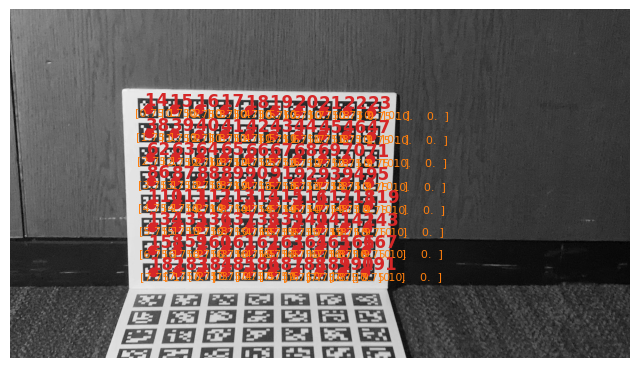

In [38]:
# Calling detect_aprilboard() with sample image
fname = './media/calibration_keyframes/keyframe_0001.jpg'
orig = cv2.imread(fname)
if len(orig.shape) == 3:
    img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
else:
    img = orig

imgpoints_fine, objpoints_fine, tagIDs_fine = detect_aprilboard(img,at_fineboard,at_detector)
print("{}, fine: {} imgpts, {} objpts".format(fname, len(imgpoints_fine),len(objpoints_fine)))
fig,ax =  plt.subplots(figsize=(8,12))
plt.imshow(img / 255.0, cmap="gray")
plt.axis('off')
for i in range(len(imgpoints_fine)):
    ax.plot(imgpoints_fine[i,0], imgpoints_fine[i,1],marker='o',color='#d62728')
    ax.text(imgpoints_fine[i,0]-10,
            imgpoints_fine[i,1]-10,
            "{} ".format(tagIDs_fine[i]),
            color='#d62728',
            fontsize=12,
            fontweight='bold')
    ax.text(imgpoints_fine[i,0]-40,
            imgpoints_fine[i,1]+20,
            np.array2string(objpoints_fine[i,:]),
            color='#ff7f0e',
            fontsize=8)

plt.show()

# Detecting Key Features

In [39]:
def in2hom(X):
    '''
    Converts from Nxm inhomogeneous coords to Nx(m+1) homogeneous coords

    Parameters:
        X: Nxm matrix in inhomogeneous coordinates

    Returns:
        Array: Nx(m+1) homogeneous coordinates
    '''
    if X.ndim == 1:
        X = X.reshape(1, -1)
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

def hom2in(X):
  '''
  Converts from Nxm homogeneous coords to Nx(m-1) inhomogeneous coords

  Parameters:
      X: Nxm matrix in homogeneous coordinates

  Returns:
      Array: Nx(m-1) matrix in inhomogeneous coordinates
  '''
  return X[:, :-1] / X[:, -1:]

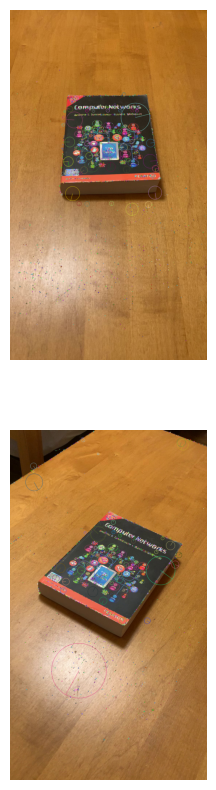

In [41]:
im1 = cv2.cvtColor(cv2.imread('./media/book2_keyframes/keyframe_0001.jpg'), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread('./media/book2_keyframes/keyframe_0003.jpg'), cv2.COLOR_BGR2RGB)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(im1, None)
keypoints2, descriptors2 = sift.detectAndCompute(im2, None)

imKeypoints1=cv2.drawKeypoints(im1,
                              keypoints1,
                              None,
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imKeypoints2=cv2.drawKeypoints(im2,
                              keypoints2,
                              None,
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

f, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.imshow(imKeypoints1)
ax1.axis('off')
ax2.imshow(imKeypoints2)
ax2.axis('off')
plt.show()

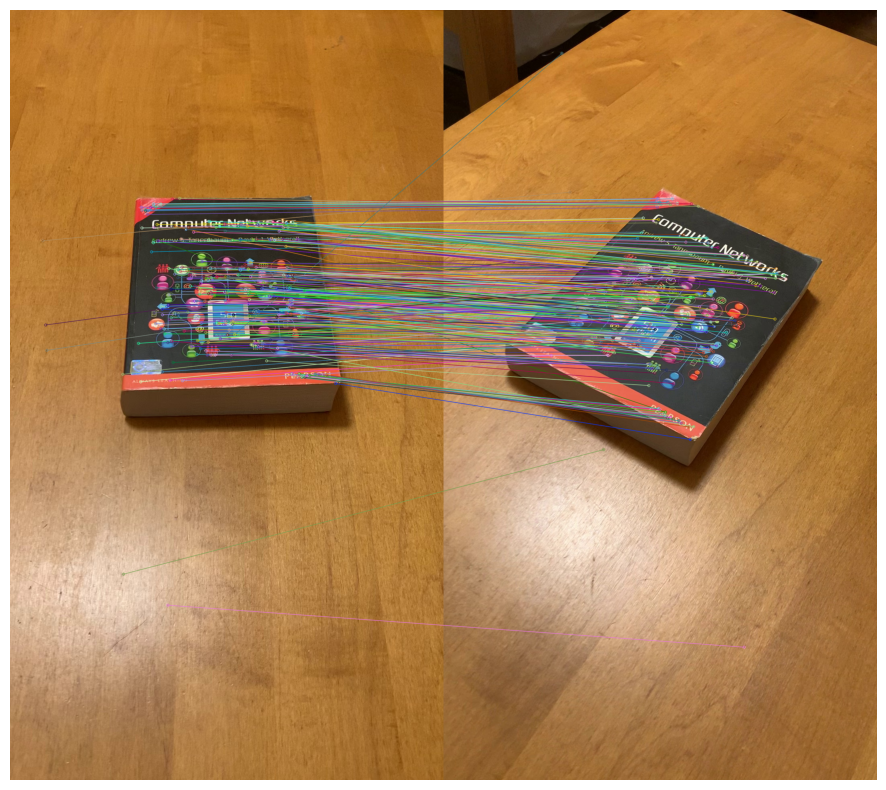

In [42]:
def find_matches(keypoints1, keypoints2, descriptors1, descriptors2, ratio_threshold):
    bf = cv2.BFMatcher(cv2.NORM_L2)

    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    X1 = np.array([keypoints1[match.queryIdx].pt for match in good_matches])
    X2 = np.array([keypoints2[match.trainIdx].pt for match in good_matches])

    X1_hom = in2hom(X1)
    X2_hom = in2hom(X2)

    return good_matches, X1_hom, X2_hom

RATIO_THRESHOLD = 0.75

matches, X1_hom, X2_hom = find_matches(keypoints1, keypoints2, descriptors1, descriptors2, RATIO_THRESHOLD)

im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(im_matches)
plt.axis('off')
plt.show()

In [45]:
print(X1_hom.shape)
print(X2_hom.shape)
X1 = hom2in(X1_hom)
X2 = hom2in(X2_hom)
print(X1.shape)
print(X2.shape)

(315, 3)
(315, 3)
(315, 2)
(315, 2)


In [46]:
F, mask = cv2.findFundamentalMat(X1, X2, cv2.FM_RANSAC)

X1_inliers = X1[mask.ravel() == 1]
X2_inliers = X2[mask.ravel() == 1]

U, S, Vt = np.linalg.svd(F)

S[2] = 0

F_rank2 = U @ np.diag(S) @ Vt

lines1 = cv2.computeCorrespondEpilines(X2_inliers.reshape(-1, 1, 2), 2, F_rank2)
lines1 = lines1.reshape(-1, 3)
lines2 = cv2.computeCorrespondEpilines(X1_inliers.reshape(-1, 1, 2), 1, F_rank2)
lines2 = lines2.reshape(-1, 3)

E = calMatrix.T @ F @ calMatrix
_, R, t, mask_pose = cv2.recoverPose(E, X1_inliers, X2_inliers, calMatrix)
P1 = calMatrix @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = calMatrix @ np.hstack((R, t))

points_4d_hom = cv2.triangulatePoints(P1, P2, X1_inliers.reshape(2, -1), X2_inliers.reshape(2, -1))
points_3d = cv2.convertPointsFromHomogeneous(points_4d_hom.T)

print("X1_hom shape:", X1_hom.shape)
print("X2_hom shape:", X2_hom.shape)
print("Inliers shape after RANSAC:", X1_inliers.shape, X2_inliers.shape)
print("Rotation matrix R:", R)
print("Translation vector t:", t)
print("3D points shape:", points_3d.shape)

X1_hom shape: (315, 3)
X2_hom shape: (315, 3)
Inliers shape after RANSAC: (240, 2) (240, 2)
Rotation matrix R: [[ 0.82 -0.57 -0.01]
 [ 0.57  0.82  0.09]
 [-0.05 -0.08  1.  ]]
Translation vector t: [[-0.22]
 [-0.01]
 [ 0.98]]
3D points shape: (240, 1, 3)


In [49]:
points = points_3d.squeeze()
x, y, z = points[:, 0], points[:, 1], points[:, 2]
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2, color=z, colorscale='Viridis', opacity=0.8))])
fig.update_layout(title='3D Point Cloud from SfM', autosize=False, width=800, height=800, margin=dict(l=65, r=50, b=65, t=90))
fig.show()